In [1]:
SEQ_LEN = 7
TEST_DAYS = 5

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler ,LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError
from keras.metrics import MeanSquaredError as MSE
from keras.optimizers import Adam

In [3]:
def modify_mean_absolute_percentage_error(y_test, y_pred):
    return np.mean(np.abs((y_pred - y_test) / (1 + y_test))) * 100

In [4]:
# Read the dataset
df = pd.read_csv(r'../data/processed/data_for_model.csv')

In [5]:
df = df[[
    'itemid', 
    'rolling_mean_7d', 
    'rolling_max_7d',
    'rolling_min_7d',
    'rolling_std_7d',
    'daily_sales_lag_1d',
    'daily_sales_lag_2d',
    'daily_sales_lag_3d',
    'daily_sales_lag_4d',
    'daily_sales_lag_5d',
    'daily_sales_lag_6d',
    'daily_sales_lag_7d',
    'daily_sales',
    'date'

    
]]


In [6]:
#df.drop(columns=['shopid'], inplace=True)

In [7]:
# Tạo các chuỗi thời gian cho LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    Y = data['daily_sales']
    data = data.drop(columns=['date'], axis=1)
    for i in range(seq_length, len(data)):
        x.append(data.iloc[i-seq_length:i, :].values)
        y.append(Y.iloc[i])  
    return np.array(x), np.array(y)

In [8]:
# sample = pd.DataFrame({'date': pd.date_range(start='1/1/2021', periods=30) , 'daily_sales': list(range(1,31)), 'squared_daily_sales': [x**2 for x in range(1,31)]})

In [9]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
def train_test_split(data, seq_length, test_days):
    x, y = create_sequences(data, seq_length)
    train_size = x.shape[0] - test_days 
    X_train = x[:train_size]
    y_train = y[:train_size]
    X_test = x[train_size:]
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

In [10]:
df['date'] = pd.to_datetime(df['date'])

In [11]:

# Giả định `df` đã được đọc vào từ file CSV và có các cột `itemid`, `date` và `sales_predict_day`
df.sort_values(['itemid', 'date'], inplace=True)

item_ids = df['itemid'].unique()
X_train_list, y_train_list, X_test_list, y_test_list = [], [], [], []

# Lặp qua từng itemid
for item_id in item_ids:
    item_data = df[df['itemid'] == item_id]
    item_data = item_data.drop('itemid', axis=1)
    X_train_item, y_train_item, X_test_item, y_test_item = train_test_split(item_data, SEQ_LEN, TEST_DAYS)

    X_train_list.append(X_train_item)
    y_train_list.append(y_train_item)
    X_test_list.append(X_test_item)
    y_test_list.append(y_test_item)

# Chuyển đổi danh sách thành numpy array
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Khởi tạo MinMaxScaler
scaler = MinMaxScaler()
num_features = X_train.shape[2]  # Số lượng tính năng
X_train = scaler.fit_transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)


In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(54990, 7, 12) (54990,) (15275, 7, 12) (15275,)


In [13]:
# Xây dựng mô hình LSTM với Dropout layers
model = Sequential()
model.add(LSTM(units =32 , return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dense(units = 1))
model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MSE()])
model.summary()

c:\Users\ducli\miniconda3\envs\KLTN\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 32)          │         5,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 7, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,681 (248.75 KB)

 Trainable params: 63,681 (248.75 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Convert numpy array to pandas DataFrame
df_y_test = pd.DataFrame(y_test)

# Use describe() method on the DataFrame
df_y_test.describe()

,0
count,15275.000000
mean,4.527660
std,9.754365
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,86.000000


In [15]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 7/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val

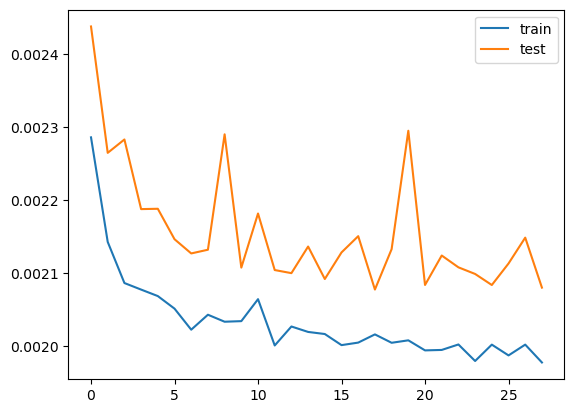

In [16]:
from matplotlib import pyplot

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [17]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

478/478 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [18]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mMAPE = modify_mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2: {r2}")
print(f"Modify Mean Absolute Percentage Error (mMAPE): {mMAPE}")

Mean Absolute Error (MAE): 2.2586731436297467
Mean Squared Error (MSE): 26.742985370416193
Root Mean Squared Error (RMSE): 5.171362042094538
R^2: 0.7189133008381678
Modify Mean Absolute Percentage Error (mMAPE): 266.67302970872663


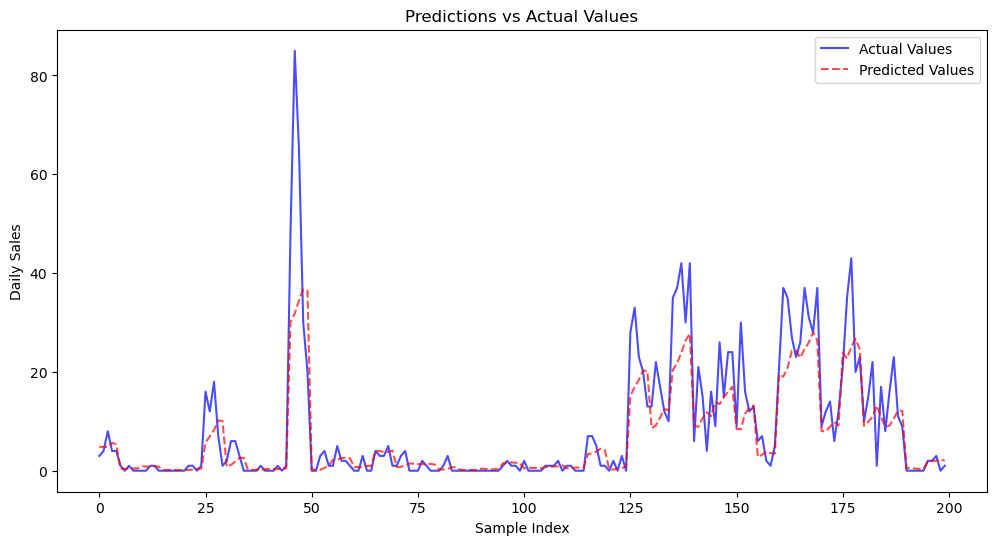

In [19]:
# Plot predictions vs actual values with enhancements
plt.figure(figsize=(12, 6))
plt.plot(y_test[:200], 'b-', label='Actual Values', alpha=0.7)  # Plotting only the first 100 samples for clarity
plt.plot(y_pred[:200], 'r--', label='Predicted Values', alpha=0.7)
plt.title('Predictions vs Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('Daily Sales')
plt.legend()
plt.show()